# Necessary imports

In [1]:
!pip install gymnasium torch numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 KB 8.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 50.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 33.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 22.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 20.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━

In [135]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random
from torch.functional import F
import datetime
import matplotlib.pyplot as plt

# Constants

In [3]:
LR = 0.001
BUFFER_SIZE = 100_000
BATCH_SIZE = 128
GAMMA = 0.99
UPDATE_LAG = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Dueling DQN

In [5]:
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, seed, num_layers, num_nodes, type: int):
        super(DuelingDQN, self).__init__()
        ss = state_size
        self.seed = torch.manual_seed(seed)
        self.fc_val = nn.ModuleList()
        for _ in range(num_layers):
            self.fc_val.append(nn.Linear(state_size, num_nodes))
            self.fc_val.append(nn.ReLU())
            state_size = num_nodes
        self.fc_val.append(nn.Linear(num_nodes, 1))
        self.fc_val = nn.Sequential(*self.fc_val)        

        state_size = ss

        self.fc_adv = nn.ModuleList()
        for _ in range(num_layers):
            self.fc_adv.append(nn.Linear(state_size, num_nodes))
            self.fc_adv.append(nn.ReLU())
            state_size = num_nodes
        self.fc_adv.append(nn.Linear(num_nodes, action_size))
        self.fc_adv = nn.Sequential(*self.fc_adv)        

        self.type = type

    def forward(self, x: torch.Tensor):
        val = self.fc_val(x)
        adv = self.fc_adv(x)

        if self.type == 1:
            return val + adv - adv.mean()
        else:
            return val + adv - adv.max()

In [6]:
class Agent:
    def __init__(self, state_size, action_size, num_layers, num_nodes, seed, type, lr = LR):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.local = DuelingDQN(state_size, action_size, seed, num_layers, num_nodes, type).to(device)
        self.target = DuelingDQN(state_size, action_size, seed, num_layers, num_nodes, type).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=lr)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0


    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        self.t_step +=  1
        if self.t_step % UPDATE_LAG == 0:
            self.update_target()

    def update_target(self):
        self.target.load_state_dict(self.local.state_dict())

    def act(self, state, policy, eps=0., tau=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local.eval()
        with torch.no_grad():
            action_values = self.local(state)
        self.local.train()

        if policy == 'eps':
            if random.random() > eps:
                return np.argmax(action_values.cpu().data.numpy())
            else:
                return random.choice(np.arange(self.action_size))
        else:
            act = action_values.cpu().data.numpy()
            act = act - np.max(act)
            exp = np.exp(act / tau)
            probs = exp / np.sum(exp)
            return np.random.choice(np.arange(self.action_size), p=probs.squeeze())


    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()


# REINFORCE

In [7]:
class Reinforce(nn.Module):
    def __init__(self, state_size, action_size, seed, num_layers, num_nodes):
        super(Reinforce, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc = nn.ModuleList()
        for _ in range(num_layers):
            self.fc.append(nn.Linear(state_size, num_nodes))
            self.fc.append(nn.ReLU())
            state_size = num_nodes
        self.fc.append(nn.Linear(num_nodes, action_size))
        self.fc = nn.Sequential(*self.fc)

    def forward(self, x: torch.Tensor):
        return F.softmax(self.fc(x), dim=1)

    def get_action(self, state: torch.Tensor):
        # print(state)
        probs = self(state)
        probs = probs.squeeze(0)
        model = torch.distributions.Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.value_fc = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x: torch.Tensor):
      return self.value_fc(x)

# Training loop

In [8]:
# train the dueling dqn


# state_size = env.observation_space.shape[0]
# action_size = env.action_space.n

def dqn(env, agent, policy, n_episodes=10000, max_t=1000, policy_val = 1.0, decay = 1.0, thresh = -100):
    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''
    episode_score = []


    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            # print(state)
            action = None
            action = agent.act(state, policy, eps=policy_val, tau=policy_val)
            # print(action)
            something = env.step(action)
            # print(something)
            next_state, reward, done, _trunc,  _ = something
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        episode_score.append(score)
        policy_val = max(decay*policy_val, 0.05)


        print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=thresh:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return episode_score

# begin_time = datetime.datetime.now()

# agent = Agent(state_size=state_size,action_size = action_size,seed = 0)
# dqn(env, agent)

# time_taken = datetime.datetime.now() - begin_time

# print(time_taken)

In [127]:
def reinforce(env, model, optimizer, n_episodes = 1000, max_t = 2000, baseline = False, critic = None, critic_optimizer = None, thresh = -100):

    episode_scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(n_episodes):
        state, _ = env.reset()
        states = []
        actions = []
        rewards = []
        score = 0
        log_probs = []
        for t in range(max_t):
            # print(state)
            # state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            state = torch.from_numpy(state).float().unsqueeze(0)
            action, lp = model.get_action(state)
            # print(action)
            states.append(state)
            actions.append(action)
            log_probs.append(lp)
            next_state, reward, done, _trunc,  _ = env.step(action)
            # print(f"\rreward: {reward}", end="")
            state = next_state
            # print(reward)
            rewards.append(reward)
            score += reward
            if done:
                break
        # break
        scores_window.append(score)
        episode_scores.append(score)
        print('\rEpisode {}\tCurrent Score: {}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="")
        if np.mean(scores_window) >= thresh:
            print(f"\nEpisode completed in {i_episode} episodes.")
            break

        returns = []
        G = 0
        for s, a, r in zip(states[::-1], actions[::-1], rewards[::-1]):
            G = r + 0.99*G

            returns.append(G)
            # G.requires_grad = True
            # print(G.grad)
            # print(model(s)[0])
            # s = Variable(s)

        returns = torch.tensor(returns[::-1])
        # returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        losses = []
        value_losses = []
        for s, a, g, r, lp in zip(states, actions, returns, rewards, log_probs):
            # prob, val = model(s)
            # prob = model(s)[0][a].squeeze()
            val = 0
            if baseline:
              val = critic(s)
              # print(val[0].squeeze())
              td_error = (g - val[0].squeeze())
              value_losses.append(0.5 * (td_error ** 2))
            # print(prob.requires_grad)
            # print(lp)
            loss = -lp * (g - val)
            # print(lp, g)
            # print(loss)
            losses.append(loss)

            # print(loss, G)
            # if loss < -100:
            #     print(loss)
            # # print(loss, prob)
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
        # for i in range(len(losses)//32 - 1):
           
        # loss = torch.stack(losses[i*32:(i+1)*32]).sum()
        loss = torch.stack(losses).sum()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # print(f"\rloss:{torch.stack(losses).sum()}")
        # print(f"\rloss:{torch.sum(torch.stack(losses))}")
        # print(torch.sum(torch.stack(losses)))
        
        # for param in model.parameters():
        #     param.grad.data.clamp_(-1, 1)
            # print(param.grad.data)
        optimizer.step()
        # if baseline:
        #   value_loss.backward()

        if baseline:
          value_loss = torch.stack(value_losses).sum()
          # print(value_loss)
          critic_optimizer.zero_grad()
          value_loss.backward()
        #   for param in critic.parameters():
        #     param.grad.data.clamp_(-1, 1)
          critic_optimizer.step()
        # break

        # print("One round done")
    return episode_scores

# Environments

## Acrobot

In [10]:
env = gym.make("Acrobot-v1")
env.action_space.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [11]:
num_layers = (2, 3, 4)
num_nodes = (64, 128)
eps_vals = (0.3, 0.2, 0.1)
tau_vals = (0.5, 0.3, 0.1)
params = [(layers , n, 'eps', e) for layers in num_layers for n in num_nodes for e in eps_vals]
params += [(layers , n, 'soft', t) for layers in num_layers for n in num_nodes for t in tau_vals]
best_params = None
least_regret = -int(1e9)

### Optimize DDQN 1 for Acrobot

In [27]:
for layer, n, policy, val in params:
    print(layer, n, policy, val)
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=1)
    scores = dqn(env, agent, policy, policy_val=val)
    time_taken = datetime.datetime.now() - begin_time
    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, n, policy, val)

    print(time_taken)
    print(sum(scores)/len(scores))
print(best_params)

2 64 eps 0.3


Episode 100	Average Score: -121.31Average Score: -121.31
Episode 168	Current Score: -98.00	Average Score: -99.9651
Environment solved in 168 episodes!	Average Score: -99.96
0:00:40.806991
-112.80357142857143
2 64 eps 0.2
Episode 100	Average Score: -105.45Average Score: -105.45
Episode 107	Current Score: -95.00	Average Score: -99.2835
Environment solved in 107 episodes!	Average Score: -99.28
0:00:23.863075
-105.07476635514018
2 64 eps 0.1
Episode 100	Average Score: -107.69Average Score: -107.69
Episode 112	Current Score: -71.00	Average Score: -99.9422
Environment solved in 112 episodes!	Average Score: -99.94
0:00:25.795769
-106.47321428571429
2 128 eps 0.3
Episode 100	Average Score: -119.26	Average Score: -119.26
Episode 132	Current Score: -98.00	Average Score: -100.007
Environment solved in 132 episodes!	Average Score: -100.00
0:00:34.187453
-113.40151515151516
2 128 eps 0.2
Episode 100	Average Score: -110.34	Average Score: -110.34
Episode 113	Current Score: -89.00	Average Score: -99.7

### Optimize DDQN 2 for Acrobot

In [29]:
least_regret = -int(1e9)
for layer, n, policy, val in params:
    print(layer, n, policy, val)
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=2)
    scores = dqn(env, agent, policy, policy_val=val)
    time_taken = datetime.datetime.now() - begin_time
    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, n, policy, val)
    print(time_taken)
    print(sum(scores)/len(scores))
print(best_params)

2 64 eps 0.3


Episode 100	Average Score: -128.99Average Score: -128.99
Episode 195	Current Score: -84.00	Average Score: -99.9862
Environment solved in 195 episodes!	Average Score: -99.98
0:00:50.396191
-115.1076923076923
2 64 eps 0.2
Episode 100	Average Score: -113.24Average Score: -113.24
Episode 131	Current Score: -74.00	Average Score: -99.9559
Environment solved in 131 episodes!	Average Score: -99.95
0:00:30.777650
-107.42748091603053
2 64 eps 0.1
Episode 100	Average Score: -122.96Average Score: -122.96
Episode 142	Current Score: -88.00	Average Score: -99.7348
Environment solved in 142 episodes!	Average Score: -99.73
0:00:36.769243
-113.55633802816901
2 128 eps 0.3
Episode 100	Average Score: -125.74	Average Score: -125.74
Episode 198	Current Score: -91.00	Average Score: -99.1065
Environment solved in 198 episodes!	Average Score: -99.10
0:00:51.969632
-112.61616161616162
2 128 eps 0.2
Episode 100	Average Score: -124.85	Average Score: -124.85
Episode 121	Current Score: -78.00	Average Score: -99.865

In [14]:
least_regret = -103.49
best_params = (3, 64, 'eps', 0.2)
for layer, n, policy, val in params[18:]:
    print(layer, n, policy, val)
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=2)
    scores = dqn(env, agent, policy, policy_val=val)
    time_taken = datetime.datetime.now() - begin_time
    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, n, policy, val)
    print(time_taken)
    print(sum(scores)/len(scores))
print(best_params)

2 64 soft 0.5


Episode 100	Average Score: -126.51Average Score: -126.511
Episode 169	Current Score: -88.00	Average Score: -91.8801
Environment solved in 169 episodes!	Average Score: -91.88
0:00:43.230890
-112.9585798816568
2 64 soft 0.3
Episode 100	Average Score: -115.27Average Score: -115.27
Episode 110	Current Score: -75.00	Average Score: -99.3550
Environment solved in 110 episodes!	Average Score: -99.35
0:00:28.221013
-112.71818181818182
2 64 soft 0.1
Episode 100	Average Score: -120.97Average Score: -120.972
Episode 150	Current Score: -70.00	Average Score: -96.5080
Environment solved in 150 episodes!	Average Score: -96.50
0:00:38.246415
-111.64
2 128 soft 0.5
Episode 100	Average Score: -110.11	Average Score: -110.11
Episode 108	Current Score: -60.00	Average Score: -99.1613
Environment solved in 108 episodes!	Average Score: -99.16
0:00:27.536486
-109.21296296296296
2 128 soft 0.3
Episode 100	Average Score: -124.82Average Score: -124.82
Episode 151	Current Score: -80.00	Average Score: -98.7433
Envir

### Optimize Reinforce 1 for Acrobot

In [120]:
num_layers = (2, 3, 4)
num_nodes = (64, 128)
params = [(layers , n, 'eps', 0) for layers in num_layers for n in num_nodes]
# params += [(layers , n, 'soft', t) for layers in num_layers for n in num_nodes for t in tau_vals]
best_params = None
least_regret = -int(1e9)

In [80]:
least_regret = -int(1e9)
for layer, nodes, _, _ in params[1:]:
    print(layer, nodes)
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)

    optimizer = optim.SGD(model.parameters(), lr=0.00001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = 0)
    critic_optimizer = optim.Adam(critic.parameters(), lr=LR)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, baseline=False, critic = critic, critic_optimizer = critic_optimizer)
    time_taken = datetime.datetime.now() - begin_time
    print(time_taken)

    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, nodes)
    print(sum(scores)/len(scores))
print(best_params)

2 128


Episode 886	Current Score: -91.0	Average Score: -99.93347
Episode completed in 886 episodes.
0:01:41.505891
-151.74520856820743
3 64
Episode 999	Current Score: -279.0	Average Score: -138.7280:03:37.903416
-266.832
3 128
Episode 873	Current Score: -83.0	Average Score: -99.90748
Episode completed in 873 episodes.
0:02:12.237661
-183.52974828375287
4 64
Episode 999	Current Score: -121.0	Average Score: -201.970:06:41.384486
-455.37
4 128
Episode 999	Current Score: -147.0	Average Score: -145.590:05:38.894365
-375.831
(2, 128)


### Optimize Reinforce 2 for Acrobot

In [32]:
num_layers = (2, 3, 4)
num_nodes = (64, 128)
eps_vals = (0.3, 0.2, 0.1)
tau_vals = (0.3, 0.1)
# params = [(layers , n, 'eps', e) for layers in num_layers for n in num_nodes for e in eps_vals]
params = [(layers , n, 'soft', t) for layers in num_layers for n in num_nodes for t in tau_vals]
best_params = None
least_regret = -int(1e9)

In [119]:
least_regret = -int(1e9)
for layer, nodes, _, _ in params[1:]:
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)
    print(layer, nodes)
    optimizer = optim.SGD(model.parameters(), lr=0.00001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = -1)
    critic_optimizer = optim.SGD(critic.parameters(), lr=0.000001)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, baseline=True, critic = critic, critic_optimizer = critic_optimizer)
    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    if least_regret > sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, nodes)
    print(sum(scores)/len(scores))
print(best_params)
    

2 128


Episode 945	Current Score: -103.0	Average Score: -99.2079
Episode completed in 945 episodes.
0:02:25.474518
-141.3784355179704
3 64
Episode 999	Current Score: -128.0	Average Score: -151.710:04:32.329385
-235.475
3 128
Episode 999	Current Score: -101.0	Average Score: -106.950:04:01.381560
-204.556
4 64
Episode 999	Current Score: -144.0	Average Score: -167.460:05:50.015319
-283.551
4 128
Episode 999	Current Score: -146.0	Average Score: -142.03180:08:04.755695
-379.956
(2, 128)


## CartPole

In [121]:
env = gym.make("CartPole-v1")
env.action_space.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [30]:
num_layers = (3, 4)
num_nodes = (64, 128)
eps_vals = (0.3, 0.2, 0.1)
# tau_vals = (1000)
# params = [(layers , n, 'eps', e) for layers in num_layers for n in num_nodes for e in eps_vals]
params = [(layers , n, 'soft', 5000) for layers in num_layers for n in num_nodes]
best_params = None
least_regret = -int(1e9)

### Optimize DDkewN type 1

In [31]:
least_regret = -int(1e9)
for layer, n, policy, val in params:
    print(layer, n, policy, val)
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=1, lr=0.001)
    scores = dqn(env, agent, policy, policy_val=val, thresh=200, decay=0.9999)
    time_taken = datetime.datetime.now() - begin_time
    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, n, policy, val)

    print(time_taken)
    print(sum(scores)/len(scores))
print(best_params)

3 64 soft 5000
Episode 12	Current Score: 31.00	Average Score: 20.08

Episode 100	Average Score: 22.10	Average Score: 22.10
Episode 200	Average Score: 162.20	Average Score: 162.20
Episode 222	Current Score: 203.00	Average Score: 200.49
Environment solved in 222 episodes!	Average Score: 200.49
0:01:08.906206
109.18018018018019
3 128 soft 5000
Episode 100	Average Score: 21.22	Average Score: 21.22
Episode 200	Average Score: 199.48	Average Score: 199.48
Episode 201	Current Score: 199.00	Average Score: 201.24
Environment solved in 201 episodes!	Average Score: 201.24
0:01:03.847081
110.7910447761194
4 64 soft 5000
Episode 100	Average Score: 23.67	Average Score: 23.67
Episode 192	Current Score: 146.00	Average Score: 200.05
Environment solved in 192 episodes!	Average Score: 200.05
0:01:10.739965
115.6875
4 128 soft 5000
Episode 100	Average Score: 23.89	Average Score: 23.89
Episode 188	Current Score: 394.00	Average Score: 201.67
Environment solved in 188 episodes!	Average Score: 201.67
0:01:11.273700
118.54787234042553
(4, 128, 'soft', 5000)


### Optimize DDkewN type 2

In [35]:
num_layers = (3, 4)
num_nodes = (64, 128)
eps_vals = (0.3, 0.2, 0.1)
# tau_vals = (1000)
# params = [(layers , n, 'eps', e) for layers in num_layers for n in num_nodes for e in eps_vals]
params = [(layers , n, 'soft', 1) for layers in num_layers for n in num_nodes]
best_params = None
least_regret = -int(1e9)

In [36]:
least_regret = -int(1e9)
for layer, n, policy, val in params:
    print(layer, n, policy, val)
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=2, lr=0.001)
    scores = dqn(env, agent, policy, policy_val=val, thresh=200, decay=0.9999)
    time_taken = datetime.datetime.now() - begin_time
    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, n, policy, val)

    print(time_taken)
    print(sum(scores)/len(scores))
print(best_params)

3 64 soft 1
Episode 11	Current Score: 34.00	Average Score: 22.09

Episode 81	Current Score: 1000.00	Average Score: 208.21
Environment solved in 81 episodes!	Average Score: 208.21
0:00:48.579655
208.20987654320987
3 128 soft 1
Episode 49	Current Score: 1000.00	Average Score: 207.76
Environment solved in 49 episodes!	Average Score: 207.76
0:00:29.254604
207.75510204081633
4 64 soft 1
Episode 64	Current Score: 1000.00	Average Score: 203.95
Environment solved in 64 episodes!	Average Score: 203.95
0:00:41.967979
203.953125
4 128 soft 1
Episode 71	Current Score: 888.00	Average Score: 203.258
Environment solved in 71 episodes!	Average Score: 203.25
0:00:45.593708
203.25352112676057
(3, 64, 'soft', 1)


### Optimize Reinforce type 1

In [130]:
least_regret = -int(1e9)
for layer, nodes, _, _ in params:
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)
    print(layer, nodes)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = -1)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, baseline=False, critic = critic, critic_optimizer = critic_optimizer, thresh = 200)
    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, nodes)
    print(sum(scores)/len(scores))
print(best_params)

2 64
Episode 5	Current Score: 30.0	Average Score: 15.50

Episode 526	Current Score: 275.0	Average Score: 200.65
Episode completed in 526 episodes.
0:00:39.704388
121.54459203036053
2 128
Episode 540	Current Score: 2000.0	Average Score: 215.93
Episode completed in 540 episodes.
0:00:40.660065
117.39186691312385
3 64
Episode 221	Current Score: 108.0	Average Score: 200.28
Episode completed in 221 episodes.
0:00:17.457195
107.73423423423424
3 128
Episode 999	Current Score: 124.0	Average Score: 133.110:01:01.674060
78.661
4 64
Episode 341	Current Score: 160.0	Average Score: 200.90
Episode completed in 341 episodes.
0:00:24.563518
85.33333333333333
4 128
Episode 999	Current Score: 9.0	Average Score: 9.300:00:23.731076
10.68
(2, 64)


### Optimize Reinforce type 2

In [129]:
least_regret = -int(1e9)
for layer, nodes, _, _ in params:
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)
    print(layer, nodes)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = -1)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, baseline=True, critic = critic, critic_optimizer = critic_optimizer, thresh = 200)
    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    if least_regret < sum(scores)/len(scores):
        least_regret = sum(scores)/len(scores)
        best_params = (layer, nodes)
    print(sum(scores)/len(scores))
print(best_params)

2 64
Episode 5	Current Score: 19.0	Average Score: 13.50

Episode 499	Current Score: 1258.0	Average Score: 202.40
Episode completed in 499 episodes.
0:01:00.971197
118.994
2 128
Episode 356	Current Score: 454.0	Average Score: 200.67
Episode completed in 356 episodes.
0:00:37.397123
93.84873949579831
3 64
Episode 257	Current Score: 616.0	Average Score: 204.710
Episode completed in 257 episodes.
0:00:29.877406
99.76356589147287
3 128
Episode 989	Current Score: 2000.0	Average Score: 202.57
Episode completed in 989 episodes.
0:02:00.703767
112.61313131313132
4 64
Episode 293	Current Score: 247.0	Average Score: 200.43
Episode completed in 293 episodes.
0:00:33.050459
88.35714285714286
4 128
Episode 999	Current Score: 35.0	Average Score: 30.060:01:07.246530
41.055
(2, 64)


# Acrobot Best Model comparision

## Dueling-DQN

### Type 1

In [132]:
env = gym.make("Acrobot-v1")
env.action_space.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [141]:
best_params = (2, 128, 'soft', 0.3)
dd_type_1_scores = []
layer, n, policy, val = best_params
print(layer, n, policy, val)
for i in range(5):
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=1)
    scores = dqn(env, agent, policy, policy_val=val, n_episodes=150, thresh = 0)
    time_taken = datetime.datetime.now() - begin_time
    print(time_taken)
    print(sum(scores)/len(scores))
    dd_type_1_scores.append(scores)

2 128 soft 0.3


Episode 100	Average Score: -114.38	Average Score: -114.38
Episode 150	Current Score: -76.00	Average Score: -97.810:01:08.765401
-109.2
Episode 100	Average Score: -125.18	Average Score: -125.18
Episode 150	Current Score: -90.00	Average Score: -107.350:01:15.715434
-115.62666666666667
Episode 100	Average Score: -115.26Average Score: -115.26
Episode 150	Current Score: -100.00	Average Score: -93.440:01:06.394082
-107.39333333333333
Episode 100	Average Score: -114.22Average Score: -114.22
Episode 150	Current Score: -106.00	Average Score: -99.800:01:10.248910
-110.56666666666666
Episode 100	Average Score: -141.85Average Score: -141.850
Episode 150	Current Score: -89.00	Average Score: -108.850:01:21.550429
-127.2


In [170]:
def show_rewards(*reward_avgs_list, title = "Type 1"):
    plt.figure()
    for i, reward_avgs in enumerate(reward_avgs_list):
        reward_avgs = np.array(reward_avgs)

    # Calculate mean and standard deviation
        reward_mean = np.mean(reward_avgs, axis=0)
        reward_std = np.std(reward_mean)

    # Plotting rewards
        if i % 2 == 0:
            plt.plot(reward_mean, label=title, color='blue')
        else:
            plt.plot(reward_mean, label='Type 2', color='red')
            
        plt.fill_between(range(len(reward_mean)), reward_mean - reward_std, reward_mean + reward_std, alpha=0.5)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.legend()
    plt.show()


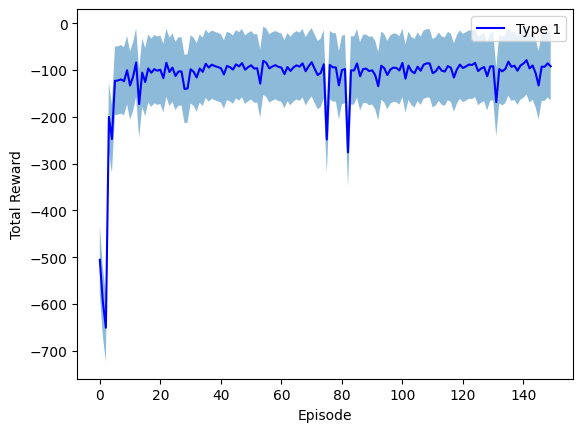

In [171]:
show_rewards(dd_type_1_scores)

### Type 2

In [144]:
best_params = (3, 64, 'soft', 0.1)
dd_type_2_scores = []
layer, n, policy, val = best_params
print(layer, n, policy, val)
for i in range(5):
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=2)
    scores = dqn(env, agent, policy, policy_val=val, n_episodes=150, thresh = 0)
    time_taken = datetime.datetime.now() - begin_time
    print(time_taken)
    print(sum(scores)/len(scores))
    dd_type_2_scores.append(scores)

3 64 soft 0.1
Episode 100	Average Score: -113.65Average Score: -113.65
Episode 150	Current Score: -75.00	Average Score: -98.100:01:26.137462
-107.68666666666667
Episode 100	Average Score: -111.26Average Score: -111.26
Episode 150	Current Score: -73.00	Average Score: -92.620:01:16.376705
-103.36666666666666
Episode 100	Average Score: -101.05	Average Score: -101.05
Episode 150	Current Score: -86.00	Average Score: -88.840:01:15.107326
-98.31333333333333
Episode 100	Average Score: -99.89	Average Score: -99.894
Episode 150	Current Score: -83.00	Average Score: -85.110:01:13.901526
-94.32666666666667
Episode 100	Average Score: -101.700	Average Score: -101.70
Episode 150	Current Score: -95.00	Average Score: -99.830:01:21.052334
-99.38


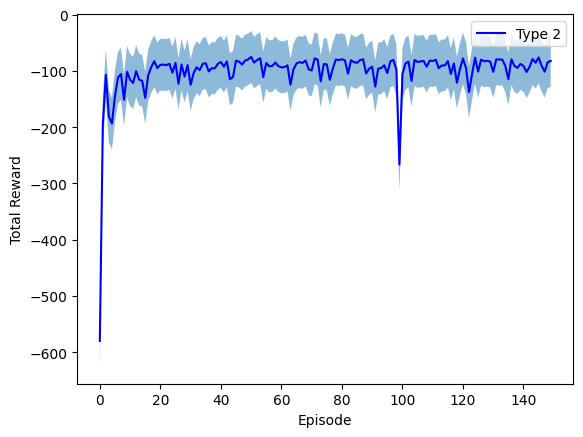

In [172]:
show_rewards(dd_type_2_scores, title="Type 2")

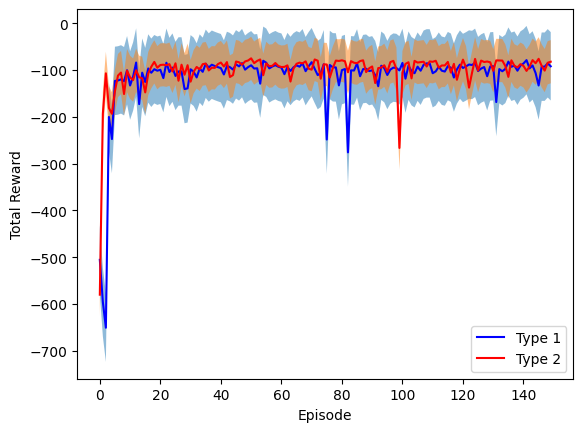

In [173]:
show_rewards(dd_type_1_scores, dd_type_2_scores)

## REINFORCE

### Type 1

In [179]:
best_params = (2, 128)
layer, nodes = best_params
reinforce_type_1 = []
print(layer, nodes)
for layer, nodes, _, _ in params[1:]:
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)

    optimizer = optim.SGD(model.parameters(), lr=0.00001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = 0)
    critic_optimizer = optim.Adam(critic.parameters(), lr=LR)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, n_episodes = 700, baseline=False, critic = critic, critic_optimizer = critic_optimizer, thresh = 0)
    time_taken = datetime.datetime.now() - begin_time
    print(time_taken)
    reinforce_type_1.append(scores)

2 128


Episode 699	Current Score: -150.0	Average Score: -126.920:01:39.868090
Episode 699	Current Score: -165.0	Average Score: -164.610:06:00.612767
Episode 699	Current Score: -108.0	Average Score: -145.300:02:23.620912
Episode 699	Current Score: -136.0	Average Score: -148.810:03:49.227211
Episode 699	Current Score: -178.0	Average Score: -217.800:04:55.297223


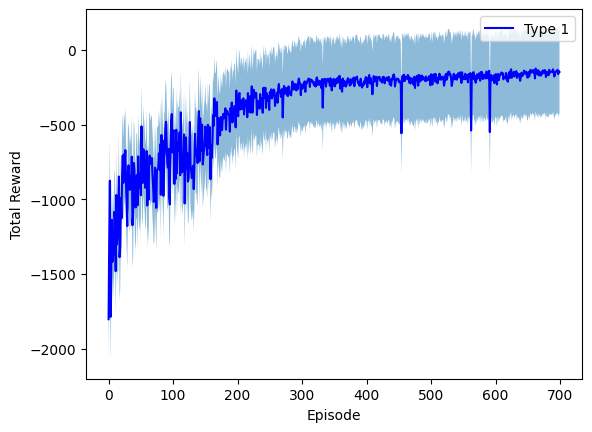

In [180]:
show_rewards(reinforce_type_1)

### Type 2

In [181]:
best_params = (2, 128)
layer, nodes = best_params
reinforce_type_2 = []
print(layer, nodes)
for layer, nodes, _, _ in params[1:]:
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)

    optimizer = optim.SGD(model.parameters(), lr=0.00001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = -1)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.000001)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, n_episodes = 700, baseline=True, critic = critic, critic_optimizer = critic_optimizer, thresh = 0)
    time_taken = datetime.datetime.now() - begin_time
    print(time_taken)
    reinforce_type_2.append(scores)

2 128
Episode 0	Current Score: -786.0	Average Score: -786.00

Episode 699	Current Score: -111.0	Average Score: -125.11060:04:49.570222
Episode 699	Current Score: -315.0	Average Score: -194.7950:04:56.417329
Episode 699	Current Score: -101.0	Average Score: -123.950:03:19.269172
Episode 699	Current Score: -204.0	Average Score: -290.150:06:05.763973
Episode 699	Current Score: -207.0	Average Score: -204.950:05:06.544853


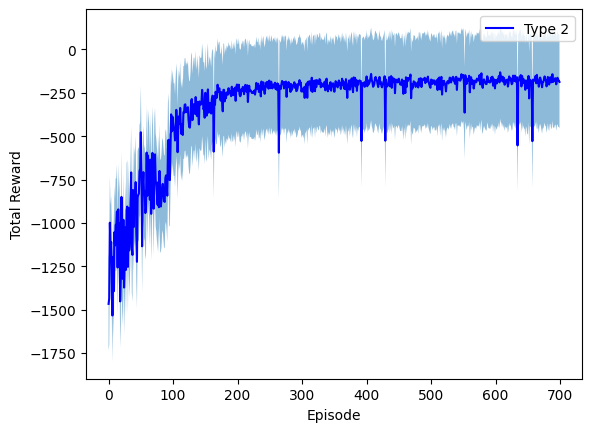

In [182]:
show_rewards(reinforce_type_2, title="Type 2")

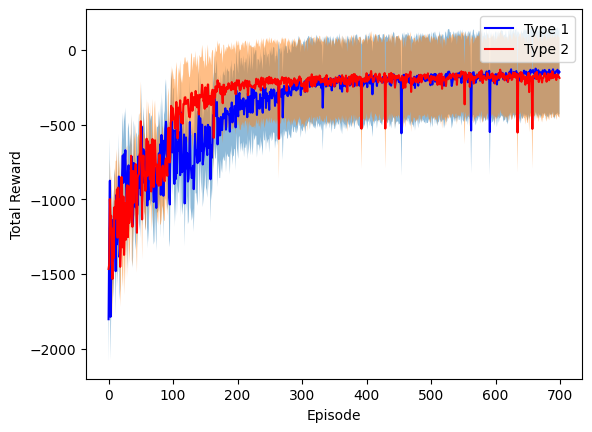

In [183]:
show_rewards(reinforce_type_1, reinforce_type_2)

# Cart Pole

In [184]:
env = gym.make("CartPole-v1")
env.action_space.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

## Double DQN

### Type 1

In [188]:
best_params = (4, 128, 'soft', 5000)
layer, n, policy, val = best_params
dd_type_1_scores_cart = []
for i in range(5):
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=1, lr=0.001)
    scores = dqn(env, agent, policy, n_episodes=250, policy_val=val, thresh=1000, decay=0.9999)
    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    print(sum(scores)/len(scores))
    dd_type_1_scores_cart.append(scores)

Episode 5	Current Score: 13.00	Average Score: 22.20

Episode 100	Average Score: 21.74	Average Score: 21.74
Episode 200	Average Score: 159.64	Average Score: 159.64
Episode 250	Current Score: 126.00	Average Score: 179.470:02:53.121241
108.408
Episode 100	Average Score: 23.77	Average Score: 23.77
Episode 200	Average Score: 177.80	Average Score: 177.80
Episode 250	Current Score: 222.00	Average Score: 188.670:03:03.414778
121.24
Episode 100	Average Score: 23.50	Average Score: 23.50
Episode 200	Average Score: 161.06	Average Score: 161.06
Episode 250	Current Score: 153.00	Average Score: 236.430:02:43.958914
115.748
Episode 100	Average Score: 22.72	Average Score: 22.72
Episode 200	Average Score: 203.59	Average Score: 203.59
Episode 250	Current Score: 50.00	Average Score: 250.080:03:28.425177
139.3
Episode 100	Average Score: 23.06	Average Score: 23.06
Episode 200	Average Score: 188.25	Average Score: 188.25
Episode 250	Current Score: 120.00	Average Score: 187.870:02:44.239591
111.36


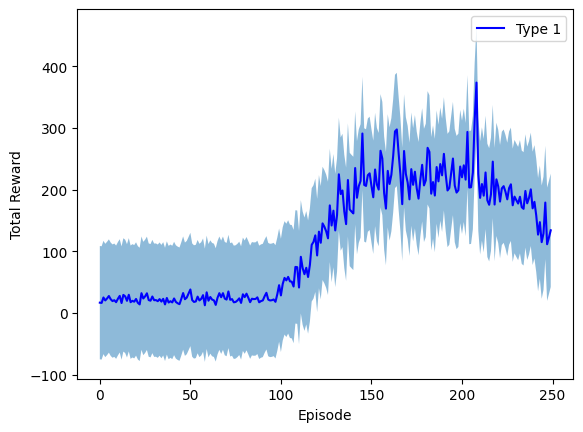

In [189]:
show_rewards(dd_type_1_scores_cart)

### Type 2

In [192]:
best_params = (3, 64, 'soft', 1)
layer, n, policy, val = best_params
dd_type_2_scores_cart = []
for i in range(5):
    begin_time = datetime.datetime.now()
    agent = Agent(state_size=state_size,action_size = action_size,seed = 0, num_layers=layer, num_nodes=n, type=2, lr=0.001)
    scores = dqn(env, agent, policy, n_episodes=250, policy_val=val, thresh=1000, decay=0.9999)
    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    print(sum(scores)/len(scores))
    dd_type_2_scores_cart.append(scores)

Episode 8	Current Score: 25.00	Average Score: 17.88

Episode 100	Average Score: 425.29	Average Score: 425.29
Episode 200	Average Score: 146.02verage Score: 146.02638
Episode 250	Current Score: 11.00	Average Score: 27.340:04:52.422620
230.4
Episode 100	Average Score: 321.910	Average Score: 321.91
Episode 200	Average Score: 432.93	Average Score: 432.937
Episode 250	Current Score: 331.00	Average Score: 325.400:08:31.870436
367.932
Episode 100	Average Score: 380.01	Average Score: 380.01
Episode 200	Average Score: 307.30	Average Score: 307.306
Episode 250	Current Score: 9.00	Average Score: 193.230:06:14.764356
279.108
Episode 100	Average Score: 259.70	Average Score: 259.70
Episode 200	Average Score: 312.15Average Score: 312.1525
Episode 250	Current Score: 13.00	Average Score: 178.030:05:38.561360
243.092
Episode 100	Average Score: 289.88Average Score: 289.888
Episode 200	Average Score: 51.55	Average Score: 51.5503
Episode 250	Current Score: 15.00	Average Score: 17.600:03:13.480249
140.704


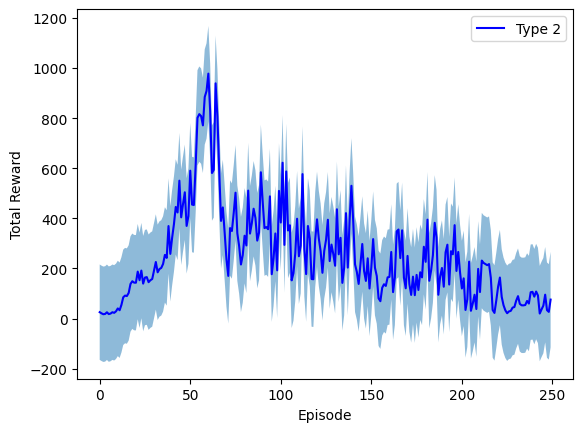

In [193]:
show_rewards(dd_type_2_scores_cart, title="Type 2")

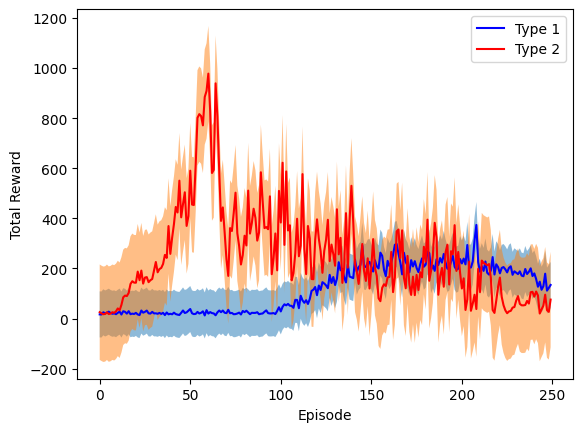

In [194]:
show_rewards(dd_type_1_scores_cart, dd_type_2_scores_cart)

## REINFORCE

In [201]:
best_params = (2, 64)
layer, nodes = best_params
print(layer, nodes)
reinforce_type_1_cart = []
for i in range(5):
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = -1)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, n_episodes=500, baseline=False, critic = critic, critic_optimizer = critic_optimizer, thresh = 1000)
    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    print(sum(scores)/len(scores))
    reinforce_type_1_cart.append(scores)

2 64
Episode 260	Current Score: 216.0	Average Score: 175.66

KeyboardInterrupt: 

In [ ]:
show_rewards(reinforce_type_1_cart)

### Type 2

In [ ]:
best_params = (2, 64)
layer, nodes = best_params
print(layer, nodes)
reinforce_type_2_cart = []
for i in range(5):
    model = Reinforce(state_size=state_size, action_size=action_size, seed=-1, num_layers=layer, num_nodes=nodes)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    critic = Critic(state_size = state_size, action_size=action_size, seed = -1)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)
    begin_time = datetime.datetime.now()
    scores = reinforce(env, model, optimizer, n_episodes=500, baseline=True, critic = critic, critic_optimizer = critic_optimizer, thresh = 1000)
    time_taken = datetime.datetime.now() - begin_time

    print(time_taken)
    print(sum(scores)/len(scores))
    reinforce_type_2_cart.append(scores)

2 64
Episode 4	Current Score: 13.0	Average Score: 12.80

Episode 499	Current Score: 175.0	Average Score: 447.3590:02:05.091725
225.92
Episode 499	Current Score: 221.0	Average Score: 420.030:01:40.470838
181.85
Episode 499	Current Score: 237.0	Average Score: 333.400:01:55.383476
209.972
Episode 499	Current Score: 242.0	Average Score: 302.460:01:24.372921
152.874
Episode 499	Current Score: 167.0	Average Score: 118.900:01:01.246742
111.926


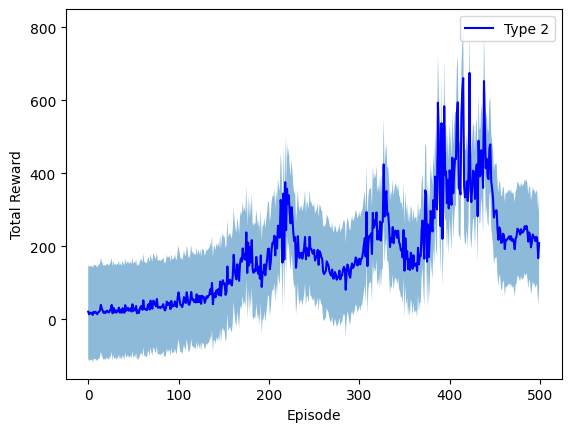

In [ ]:
show_rewards(reinforce_type_2_cart, title="Type 2")